# Primer on Softmax

Softmax is ubiquitous in Neural Network architectures when it comes to multi-classification. You can find it in the prediction layers of `ConvNets` applied to computer vision tasks e.g. ImageNet classification on 1000 categories, in the attention mechanism of `Transformers` and `Seq2Seq` models but also in econometrics to study effects of variables on a multinomial outcome e.g. how individuals choose health package based on their income level. 

Since Softmax is so widely used, it is important to understand all the nuts and bolts of it. In this post, we will first provide intuition about softmax and then go into the details of the math behind it. Finally, softmax will look at some of the problematic properties of softmax and how to deal with them in practice.

## Intuition for Softmax

In the context of Neural Networks, softmax is used to transform the output of a (usually linear) layer into a probability distribution over the classes. Consider the case when we do language modeling ie. predicting the next word in a sentence. We have a vocabulary of $V$ words and we want to predict the probability of each word in the vocabulary being the next word in the sentence conditioned on the previous words. The below chart illustrates this setup: we are trying to predict the next word conditioned on the "The quick brown fox jumps over the lazy" prefix. Using softmax, we get a probability distribution over the vocabulary of words that has a nice statistical interpretation - it is the probability of each word being the next word in the sentence - and we can use this prediction to match the ground truth word and compute the loss. In the next section, we will go into the mathematical details of how softmax works.

<div>
<img src="../images/softmax/intuition_chart.jpg" width="500"/>
</div>

## Softmax Definition and Properties

Softmax is defined as follows where $V$ is the size of the vocabulary and $x_i$ is the $i$-th element of the input vector $x$:

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{V} e^{x_j}}
$$

It is easy to see that softmax outputs a (categorical) probability distribution over the vocabulary of words since it satisfies the Kolmorogov axioms of probability: 

- The probability of an event is a non-negative real number: $\text{softmax}(x_i) \geq 0$. Exponentiation of a real number is always positive and the denominator is also positive since it is a sum of positive numbers.
- Unit measure, the probability of of the entire sample space is 1: $\sum_{i=1}^{V} \text{softmax}(x_i) = 1$. This is true because we normalize the numerator by the sum of all the numerators.
- Sigma additivity: $\text{softmax}(x_i) + \text{softmax}(x_j) = \text{softmax}(x_i + x_j)$. This is works out, too.


Let's now see an example. Consider a computer vision scenario where there are 3 classes: cat, dog and horse. We have a linear layer that outputs the following scores for each class and we want to convert these scores into probabilities using softmax. In the below example, horse has the highest score and therefore the highest probability of being the correct class.

We can also see that the probabilities are not proportional to the scores. For example, the logit of the horse is 3 and the logit of the cat is 1 but the probability of the horse is 0.67 and the probability of the cat is 0.09. This the probability of the horse is 7.4 times higher than the probability of the cat (though the logits were only 3 times higher). This is because the exponential function is a very steep function and therefore it amplifies the differences between the scores. 

Hence the name softmax: we use a **soft version of the (hard) max function** to pick the highest score and we use the exponential function to amplify the differences between the scores. The  term 'soft' is widely used in machine learning to refer to leniency or smoothness. For example, we may want to impose constraints on activations of a neural network layer to be between 0 and 1 due to interpretability reasons but we don't want to impose it in a hard fashion to help gradient flow. We may then let activations exceed or fall below 0 and 1 but we may penalize it in the loss function. This is called soft constraints.

In [16]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

logits = np.array([1.0, 2.0, 3.0])
classes = ['cat', 'dog', 'horse']

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

print('Probabilities:' ,softmax(logits))

print('Sum of probabilities: ', sum(softmax(logits)))

Probabilities: [0.09003057 0.24472847 0.66524096]
Sum of probabilities:  1.0


In order to get better intuition about softmax, consider the below contour plot. The x-axis denotes $z_j$, while the y-axis show the $\sum_{i\neq j}^{V}z_i$. The contour lines show the value of the softmax function with two arguments: $z_j$ and $\sum_{i\neq j}^{V}z_i$. We are being sloppy here because we assume that

$$
\text{exp}(\sum_{i\neq j}^{V}z_i) = \sum_{i\neq j}^{V}\text{exp}(z_i)
$$

which does not hold, of course. However, this is a good approximation when the scores are not too far apart. We can see that the softmax function is a steep function that amplifies the differences between the scores and essentially becomes `argmax` when a score is much higher than the others.

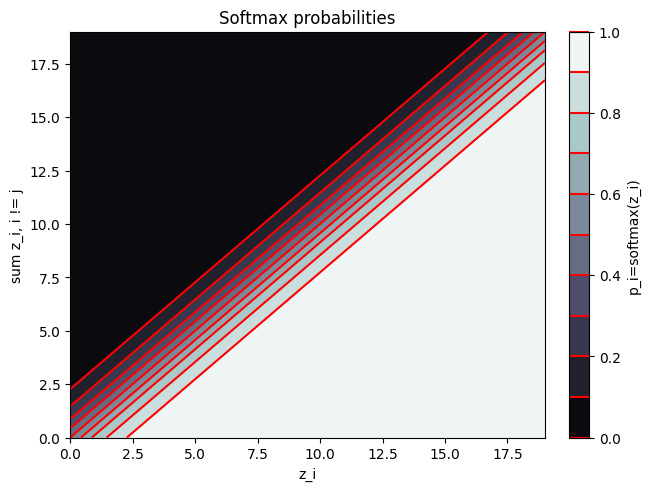

In [53]:
import matplotlib.pyplot as plt
import numpy as np

x = y = np.arange(0, 20, 1)
X, Y = np.meshgrid(x, y)

Z = np.exp(X) / (np.exp(X) + np.exp(Y))

origin='lower'
fig1, ax2 = plt.subplots(layout='constrained')
CS = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.bone, origin=origin)

CS2 = ax2.contour(CS, levels=CS.levels, colors='r', origin=origin)

ax2.set_title('Softmax probabilities')
ax2.set_xlabel('z_i')
ax2.set_ylabel('sum z_i, i != j')
cbar = fig1.colorbar(CS)

# Make a colorbar for the ContourSet returned
cbar.ax.set_ylabel('p_i=softmax(z_i)')
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)

### Numerical Stability

It may be tempting to go ahead and implement the softmax as a one-liner in our preferred deep learning framework. However, there is a catch. In practice, we usually compute softmax on an unnormalized vector called logits $z$ which are the outputs of the previous layer. 

### Quick Aside: Logits

Why do we give the output of the previous layer a special name, logits? It has its roots in statistics. The logits are the inverse of the logistic function, also known as the sigmoid function. The logistic function is used in [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) where we model a binary outcome with the linear combination of the coefficients through the sigmoid function.  The sigmoid function is defined as follows: 

$$
\text{p} = \text{sigmoid}(x) = \frac{1}{1 + e^{-x}}
$$

The inverse of the sigmoid function, the logit, is defined as follows:

$$
\text{logit}(p) = \text{sigmoid}^{-1}(p) =  \log \frac{p}{1 - p}
$$

This is why the logit is also called as the log-odds because the odds is defined as the ratio of the probability of an event happening to the probability of the event not happening ie. $p / (1 - p)$. The log-odds is the log of the odds.

In other words, the logit is the input to the sigmoid function. Similarly, we call the input to the softmax function the logits as well. We hope this clarifies the terminology.

### Back to Numerical Stability

Going back to the softmax function, we can see that the denominator is the sum of exponentials of the logits. If the logits are large, the exponentials will be even larger and we may run into numerical overflow. Conversely, if the logits are small, the exponentials will be even smaller and we may run into numerical underflow. Let's take at an example for underflow and overflow.

In [18]:
logits_large = np.array([1000., 1000., 1000.])
softmax(logits)

array([0.09003057, 0.24472847, 0.66524096])

In [19]:
logits_small = np.array([-1000., -1000., -1000.])
softmax(logits)

array([0.09003057, 0.24472847, 0.66524096])

So, what is the issue?  The logits are the same and this we expect the probabilities to be the same. However, we get nan's. This is because the exponentials of the logits are too large and we run into numerical overflow. Numpy is trying to calculate $e^{1000}$ and it is too large to represent as a floating point number (and vica-versa for $e^{-1000}$). Thus, we get nan's. This causes numerical instability in our computation and we need to fix it.

$$
\text{softmax} = \frac{\exp(x_{i})}{\sum_{j=1}^{V} \exp(x_j)}
$$

Multiply the numerator and denominator by a constant $\exp(-c)$:

$$
\text{softmax} = \frac{\exp(x_{i})*\exp(-c)}{\sum_{j=1}^{V} \exp(x_j)*\exp(-c)} \\
$$

Use the product rule of exponents to simplify the expression:

$$
\text{softmax} = \frac{\exp(x_{i}-c)}{\sum_{j=1}^{V} \exp(x_j-c)}
$$

Now, if we are clever about how we choose $c$, we can avoid numerical overflow. We can choose $c$ to be the maximum of the logits. This way, the largest logit will be 0 and the rest of the logits will be negative. This will ensure that the exponentials of the logits are not too large and we will not run into numerical overflow. Let's see this in code.

In [20]:
def softmax_stable(x):
    z = x - np.max(x)
    return np.exp(z) / np.sum(np.exp(z), axis=0)

In [21]:
softmax_stable(logits_large)

array([0.33333333, 0.33333333, 0.33333333])

In [22]:
softmax_stable(logits_small)

array([0.33333333, 0.33333333, 0.33333333])

Our numerically stable softmax implementation managed to tackle both large and small logits. 

Pytorch applies the same computation when computing Softmax. You can refer to the [C source code](https://github.com/pytorch/pytorch/blob/999abd56a7be3d73f0d2e9ab06356c7281a3307d/torch/csrc/jit/tensorexpr/operators/softmax.cpp). In case you don't want to read that, here is the docstring of the function for some context:

```c
  // Softmax is computed as follows:
  //    softmax(vi) = exp(vi) / sum(exp(vi))
  //
  // In order to avoid overflow issues due to exp of a large number, we
  // subtract the max of that dim before computing exp.
  //    softmax(vi) = exp(vi - max(vi)) / sum(exp(vi - max(vi)))
  //
  // This is implemented as 4 loopnests:
  //   - First loop computes the max over the softmax dim.
  //   - Second loop computes exp for every element in v after subtracting
  //     the max of the softmax dim it belongs to.
  //   - Third loop computes the sum over the softmax dim.
  //   - Final loop computes softmax for every element in v.
  ```

Fortunately, numpy takes away the struggles of having to do loops but if you just look at the logical steps, you will see that it is the same as the above implementation. Let's still double check if we get the same results when using pytorch's softmax.

(SIDE NOTE: Pytorch will actually use a different implementation of softmax, called `LogSoftmax` with the `NLLLOSS` , which is more numerically stable. We will review why this is the case in a later section.)

In [23]:
from torch.nn import functional as F
import torch

F.softmax(torch.tensor(logits_large), dim=0)

tensor([0.3333, 0.3333, 0.3333], dtype=torch.float64)

In [24]:
F.softmax(torch.tensor(logits_small), dim=0)

tensor([0.3333, 0.3333, 0.3333], dtype=torch.float64)

## Why do we use Cross Entropy Loss with Softmax?

We have seen that softmax converts the logits into probabilities but we still need a loss function to match our predictions with the ground truth. Why is the usual choice of loss function the cross entropy (CE) loss? Let' s investigate.

The cross entropy loss is defined as follows:

$$
\text{CE} = -\sum_{i=1}^{V} y_i \log(p_i)
$$

where $y_i$ is the ground truth probability and $p_i$ is the predicted probability (coming from softmax in this case) of the i-th class. Since we are using one-hot encoding for the ground truth, only the $y_i$ corresponding to the correct class will be 1 and the rest will be 0. Thus, the cross entropy loss simplifies to:

$$  
\text{CE} = -y_j \log(p_j)
$$

where $p_j$ refers to the predicted probability of the correct class. Recall that $p_j$ is the softmax of the logit $z_j$ corresponding to the correct class. Thus, we can write the cross entropy loss as a function of the logit $z_j$:

$$
\text{CE} = -y_j \log(\frac{\exp(z_j)}{\sum_{i=1}^{V} \exp(z_i)})
$$

Let's now take the derivative of the cross entropy loss with respect to the logits $z_j$.

First, apply chain rule (remember y is just a constant):

$$
\frac{\partial \text{CE}}{\partial z_j} = -y_j \frac{1}{p_j} \frac{\partial p_j}{\partial z_j} \\
$$

Use the definition of softmax:

$$
= -y_j \frac{1}{p_j} \frac{\partial \frac{\exp(z_j)}{\sum_{i=1}^{V} \exp(z_i)}}{\partial z_j} \\
$$

Use the quotient rule:

$$
= -y_j \frac{1}{p_j} \frac{\exp(z_j) \sum_{i=1}^{V} \exp(z_i) - \exp(z_j) \exp(z_j)}{(\sum_{i=1}^{V} \exp(z_i))^2} \\
$$

Simplify:

$$
= -y_j \frac{1}{p_j} \frac{\exp(z_j)}{\sum_{i=1}^{V} \exp(z_i)} \frac{\sum_{i=1}^{V} \exp(z_i) - \exp(z_j)}{\sum_{i=1}^{V} \exp(z_i)} \\
$$

Use definition of softmax:

$$
= -y_j\frac{1}{p_j} \text{softmax}(z_j) (1 - \text{softmax}(z_j)) \\
$$

$p_j$ is the softmax of $z_j$:

$$
= -y_j (1 - \text{softmax}(z_j)) \\
= \text{softmax}(z_j) - y_j
$$

$$
\frac{\partial \text{CE}}{\partial z_j} = p_j - y_j
$$

It turns out that the derivative of the cross entropy loss with respect to the logits is the difference between the predicted probability and the ground truth probability. This is a quite an interpretable gradient after all. If the predicted probability is close to the ground truth probability, the gradient will be small and the model will not change much. If the predicted probability is far from the ground truth probability, the gradient will be large and the model will change a lot. This is exactly what we want. We want the model to change a lot when it is wrong and change a little when it is right.

Now, what would happen if we picked a different loss function? For example, the MAE (mean absolute error). In that case, the loss is defined as:

$$
Loss = y_j - \frac{\exp(z_j)}{\sum_{i=1}^{V} \exp(z_i)}
$$

In other words, the loss is the difference between the ground truth probability and the predicted probability. Let's now inspect the derivative of the loss with respect to the logits $z_j$:

$$
\frac{\partial \text{Loss}}{\partial z_j} = - \frac{\partial \text{softmax}(z_j)}{\partial z_j}
$$

We can just copy-paste from above:

$$
\frac{\partial \text{Loss}}{\partial z_j} = - \text{softmax}(z_j) (1 - \text{softmax}(z_j))
$$

So, what is the issue here? The pickle is that the gradient can vanish when the predicted probability is close to 0 or 1. This means that the model will not change much when it is wrong and will not change much when it is right. This is not what we want. We want the model to change a lot when it is wrong and change a little when it is right. Generally, it is a good idea to keep in mind the implications of the loss function you are using in relation with prediction layer you are using.

When using the Cross Entropy Loss, our gradients behave as expected and this is why it is the usual choice of loss function when using softmax.

### Why use LogSoftmax and NLLLoss?

We are still not done with all the details of softmax. It would be tempting to just go and use [torch.nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) with [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) start training and call it a day. This would be a big mistake!

If you look at the docs you will see a note of `torch.nn.Softmax`:

> This module doesn’t work directly with NLLLoss, which expects the Log to be computed between the Softmax and itself. Use LogSoftmax instead (it’s faster and has better numerical properties).

Also, the ``torch.nn.CrossEntropyLoss`` docs say it expects raw logits and not probabilities:

> This criterion computes the cross entropy loss between input logits and target.

What is still missing? Why is it encouraged to use `torch.nn.LogSoftmax` with `torch.nn.NLLLoss`? Let's investigate.

Let's go back to our stable softmax function and consider these input logits:

In [52]:
probs = softmax_stable(np.array([-1., 10., 5000.]))
probs

array([0., 0., 1.])

The stable softmax implementation tackled the large inputs and could produce the correct probabilities. However, the gradients would still not behaving as expected. Let's see why.

In order to calculate the loss, we'll need to calculate the log of the softmax. Let's do that

In [29]:
np.log(probs)

array([-inf, -inf,   0.])

Oh no, we are back to square one because $\text{log}=0$ is not defined. Thus, the log of the softmax is not stable in its current form. We need to fix this. Let's see how.

The log of the (numerically stable) softmax is defined as where $c=\text{max}(z_i)$:

$$
\log(\text{softmax}(z_j)) = \log(\frac{\exp(z_j - c)}{\sum_{i=1}^{V} \exp(z_i - c)}) \\
$$

By applying the log rule for division:

$$
= \log(\exp(z_j - c)) - \log(\sum_{i=1}^{V} \exp(z_i - c)) \\
= z_j - c - \log(\sum_{i=1}^{V} \exp(z_i - c))
$$

Logically, if we want to recover the softmax, we'll need to exponentiate the log of the softmax:
$$
\text{softmax}(z_j) = \exp(\log(\text{softmax}(z_j))) = \exp(z_j - c - \log(\sum_{i=1}^{V} \exp(z_i - c))) \\
$$

Now, let's see how this works out with the logits $z_j$ we had before:

In [50]:
def log_softmax(x):
    z = x - np.max(x)
    return z - np.log(np.sum(np.exp(z), axis=0))

logs = log_softmax(np.array([-1., 10., 5000.]))

Recovering the softmax:

In [51]:
np.exp(logs)

array([0., 0., 1.])

We just tackled the numerical stability issue of the log of the softmax. We did this by applying the [LogSumExp](https://en.wikipedia.org/wiki/LogSumExp) trick. Again, if you look at [Pytorch's C implementation](https://github.com/pytorch/pytorch/blob/999abd56a7be3d73f0d2e9ab06356c7281a3307d/torch/csrc/jit/tensorexpr/operators/softmax.cpp#L21-L26), you will see that they are using the LogSumExp trick to calculate the log of the softmax:

```cpp
  // LogSoftmax is computed as follows:
  //    log_softmax(vi) = log(softmax(vi))
  //                    = vi - log(sum(exp(vi)))
  //
  // Using the same max trick as above:
  //    log_softmax(vi) = vi - max(vi) - log(sum(exp(vi - max(vi))))
  //
  // This is implemented as 5 loopnests:
  //   - First loop computes the max over the softmax dim.
  //   - Second loop computes exp for every element in v after subtracting
  //     the max of the softmax dim it belongs to.
  //   - Third loop computes the sum over the softmax dim.
  //   - Fourth loop computes log for every element in the sum.
  //   - Final loop computes the log_softmax for every element in v.
```

We now have understood why it is preferred to use logsoftmax. In pytorch, you have 2 options to make use of softmax:
1. Use `torch.nn.LogSoftmax` and `torch.nn.NLLLoss` and feed the logits into the logsoftmax layer
2. Use `torch.nn.CrossEntropyLoss` and feed the logits directly into the loss function

## Softmax in Transformer Attention Mechanism



Softmax is not only used in the prediction layer of a neural network. It is also used in the attention mechanism of the Transformer. The scaled dot-product attention in Vaswani et. al is defined as:

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

where $Q$ is the query, $K$ is the key, $V$ is the value and $d_k$ is the dimension of the key. The question is: why the scaling by $\sqrt{d_k}$? The authors say:

> We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

Recall that the scaling the dot product attention was key in the success of the Transformer. Thus, it is essential to understand why the scaling is needed.

The authors try to illustrate this via assuming that the entries of $Q$ and $K$ are independent random variables with mean 0 and variance 1. They show that the mean of the dot product is 1 while variance of the dot product is $d_k$. 

We can validate their findings by:

$$
\mathbb{E}[QK^T] = \mathbb{E}[\sum_{j=1}^{d_k} q_i  k_i]
$$

We assume that the entries of $Q$ and $K$ are independent random variables:
$$
= \mathbb{E}[Q]\mathbb{E}[K^T] = 0
$$

For variance because the entries of $Q$ and $K$ are independent random variables:

$$
\text{Var}(QK^T) = \text{Var}(Q)\text{Var}(K^T) = d_k (1^2) = d_k
$$

If the variation of the dot product scales with the number of dimensions, then it is an issue for the softmax. Recall, that softmax amplifies the differences between the logits. If the variance of the dot product scales with the number of dimensions, then the softmax will amplify the differences between the logits and we will end up with a very peaked distribution ie. the softmax essentially turns into a hardmax.

This is a problem because gradients will vanish. Recall the derivative of the softmax:
$$
\frac{\partial \text{softmax}(z_j)}{\partial z_j} = \text{softmax}(z_j)(1 - \text{softmax}(z_j))
$$

In [135]:
torch.manual_seed(0)
d = 512
q = torch.randn(512, 1)
k = torch.randn(512, 128)

In [110]:
a_i_unscaled = torch.matmul(q.t(), k)

In [111]:
a_i.shape

torch.Size([1, 128])

In [92]:
softmax = torch.nn.Softmax(dim=1)

In [118]:
e_i_unscaled = softmax(a_i_unscaled)

In [119]:
e_i_unscaled

tensor([[5.6749e-17, 7.0211e-32, 1.5647e-37, 1.2183e-34, 9.3770e-27, 8.1990e-26,
         1.8136e-36, 1.7959e-30, 3.7199e-34, 4.1176e-26, 2.3795e-19, 9.3190e-22,
         2.8537e-25, 2.7751e-14, 6.0148e-27, 3.0748e-26, 2.2210e-35, 1.4044e-25,
         1.2263e-32, 1.9010e-15, 5.4790e-33, 1.6882e-40, 1.4707e-18, 1.4433e-43,
         1.4378e-37, 2.1765e-37, 1.9090e-33, 2.0509e-29, 5.3652e-23, 4.0863e-27,
         7.7265e-31, 9.2336e-26, 2.2175e-26, 3.5289e-33, 1.3008e-07, 3.6469e-19,
         6.3375e-07, 7.1342e-33, 0.0000e+00, 6.5622e-30, 4.5105e-20, 5.8308e-29,
         1.6829e-26, 3.2491e-18, 3.7390e-19, 1.0109e-29, 9.9734e-04, 7.5152e-27,
         1.0100e-13, 5.0890e-13, 2.8026e-45, 1.4996e-27, 1.3765e-23, 2.3906e-42,
         4.2545e-31, 9.9900e-01, 2.3595e-11, 1.0667e-41, 1.0731e-13, 4.0984e-22,
         0.0000e+00, 1.0865e-34, 1.3412e-32, 5.5567e-40, 4.9409e-23, 1.8116e-28,
         1.1938e-31, 6.6564e-40, 9.3897e-27, 1.3870e-22, 4.2784e-18, 8.9965e-30,
         4.1533e-20, 1.5167e

<Axes: ylabel='Count'>

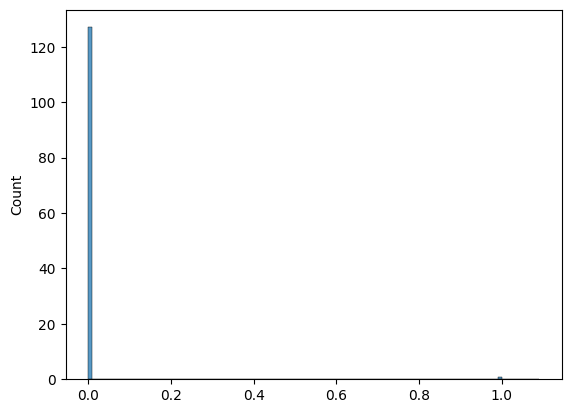

In [122]:
import seaborn as sns
sns.histplot(e_i_unscaled.numpy().flatten(), bins=np.arange(0, 1.1, 0.01))

In [123]:
d = 512
q = torch.randn(512, 1) / torch.sqrt(torch.tensor(512.))
k = torch.randn(512, 128) / torch.sqrt(torch.tensor(512.))

In [125]:
a_i_scaled = torch.matmul(q.t(), k)
e_i_scaled = softmax(a_i_scaled)

<Axes: ylabel='Count'>

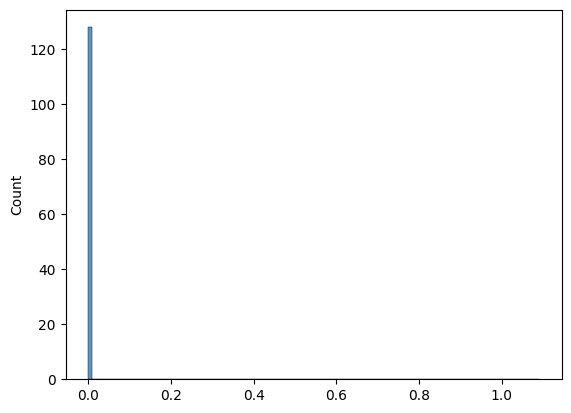

In [127]:
import seaborn as sns
sns.histplot(e_i_scaled.numpy().flatten(), bins=np.arange(0, 1.1, 0.01))

## Inductive Bias of Softmax

It is 

## Closing thoughts

Sometimes there is much more to a Neural Net layer than meets the eye. In this post, we have seen that the softmax layer is not just a simple normalization layer. It is a layer that has a lot of details and intricacies. It is important to understand the details of the layers you are using in order to be able to use them correctly and to be able to debug your models when things go wrong. I hope you enjoyed this post and that you learned something new. If you have any questions or comments, please drop me an email!

## References

https://www.deeplearningbook.org/contents/mlp.html
https://ogunlao.github.io/2020/04/26/you_dont_really_know_softmax.html
